In [1]:
from utils import *
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from scipy import optimize
from scipy.stats import spearmanr

In [2]:
noise=0.15
norm=True
ntk_depth = (3, 100)
c_val_bounds = (0.0001, 10**5)#'fixed'
corrcoef_type='p'
opt_resets=10
def bnds(p=1, n=10):
    return tuple((0.0001, 10**p) for i in range(0, n))

In [3]:
X_init, y_init = make_friedman3(noise=noise, random_state=18397425)
datasets = processing(X_init, y_init)

X, y, X_train, y_train = [None, datasets['orig'][1], None, datasets['orig train'][1]]

if norm:
    X = datasets['norm'][0]
    X_train = datasets['norm train'][0]
else:
    X = datasets['orig'][0]
    X_train = datasets['orig train'][0]

n = X.shape[1]

In [4]:
if noise != 0.0:
    ntk_1 = (
        ConstantKernel(
            constant_value=1, 
            constant_value_bounds=(1e-9, 1e2)
        ) * 
        NTK(depth=ntk_depth[0], c=2, 
            bias=1e-1, 
            bias_bounds=(1e-9, 1e0)
        ) + WhiteKernel()
    )

    ntk_2 = (
        ConstantKernel(
            constant_value=1, 
            constant_value_bounds=(1e-9, 1e2)
        ) * 
        NTK(depth=ntk_depth[1], c=2, 
            bias=1e-1, 
            bias_bounds=(1e-9, 1e0)
        ) + WhiteKernel()
    )

    lpk = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds=c_val_bounds
        ) * 
        Matern(
            nu=1/2,
            length_scale=np.array([1,1,1,1,1,1,1,1,1,1]), # anisotropic trueA
            # length_scale=1,
            length_scale_bounds='fixed'#(1e-1, 1e3), 
        ) + WhiteKernel(1, noise_level_bounds='fixed')#(0.001, 1000))
    )

else:
    ntk_1 = (
        ConstantKernel(
            constant_value=1, 
            constant_value_bounds=(1e-9, 1e2)
        ) * 
        NTK(depth=ntk_depth[0], c=2, 
            bias=1e-1, 
            bias_bounds=(1e-9, 1e0)
        ) 
    )

    ntk_2 = (
        ConstantKernel(
            constant_value=1, 
            constant_value_bounds=(1e-9, 1e2)
        ) * 
        NTK(depth=ntk_depth[1], c=2, 
            bias=1e-1, 
            bias_bounds=(1e-9, 1e0)
        ) 
    )

    lpk = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds=c_val_bounds
        ) * 
        Matern(
            nu=1/2,
            length_scale=np.array([1 for i in range(0,n)]), # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
            # length_scale=1,
            length_scale_bounds='fixed'#(1e-1, 1e3), 
        ) 
    )

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK 1    : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK 2    : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

NTK 1    :  2.34**2 * NTK(depth=3, c=2.000, bias=0.550) + WhiteKernel(noise_level=0.117)
NTK 2    :  0.146**2 * NTK(depth=100, c=2.000, bias=0.000) + WhiteKernel(noise_level=0.0605)


In [10]:
gp_ntk_1.kernel_.get_params()['k2__noise_level']

0.1172614907714475

(2,)

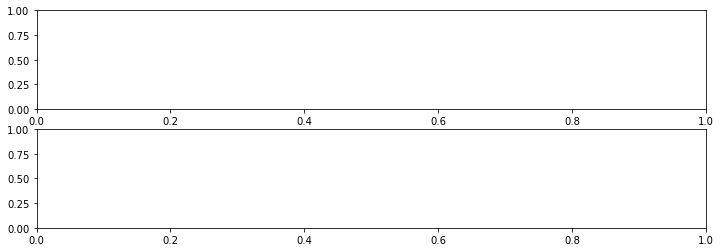

Bad pipe message: %s [b"\xd6\x19-\xa9]\xcf\x96\x1d\x15\x16\x93\x80=e\xc0$\xe4\xea \xcc\xcf\xbf\x10+[\x19lnA$\x03t\xb2\t\x10\xcf\xb9\xdb\xe1'g\xd9\x1c\x82O^\xc4\xebX\x95\xb2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00", b'']
Bad pipe message: %s [b"\xbc\xa4\xfc\x84\xa1\xa0\xb8\xb0\xc9Y2\xc1\xd0\x80\x9e\xca>=\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(12, 4))
ax.shape

In [95]:
gp_lpk = GPR(
    kernel=lpk, 
    alpha=1e-9, 
    normalize_y=True, 
    n_restarts_optimizer=0, 
    random_state=3480795)

def g(ell, gp, residual, typ, p_or_s = 'p'):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})
    
    gp.fit(X_train, y_train)
    mean = gp.predict(X)

    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [99]:
method = 'CG'
ell_lpk_1 = optimize.minimize(g, np.array([np.random.rand()*np.random.randint(1, 1000) for i in range(0,n)]), method=method, args=(gp_lpk, y-mean_ntk_1, '1:', corrcoef_type), )#bounds=bnds(n=n))
# for i in range(0, opt_resets):
#     tmp = optimize.minimize(g, np.array([np.random.rand()*10 for i in range(0,n)]), method=method, args=(gp_lpk, y-mean_ntk_1, '1:', corrcoef_type), )#bounds=bnds(p=i, n=n))
#     if tmp.fun < ell_lpk_1.fun:
#         ell_lpk_1 = tmp 
        
ell_lpk_2 = optimize.minimize(g, np.array([np.random.rand()*np.random.randint(1, 1000) for i in range(0,n)]), method=method, args=(gp_lpk, y-mean_ntk_2, '2:', corrcoef_type), )#bounds=bnds(n=n))
# for i in range(0, opt_resets):
#     tmp = optimize.minimize(g, np.array([np.random.rand()*10 for i in range(0,n)]), method=method, args=(gp_lpk, y-mean_ntk_2, '2:', corrcoef_type), )#bounds=bnds(p=i, n=n))
#     if tmp.fun < ell_lpk_2.fun:
#         ell_lpk_2 = tmp

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.


In [100]:
ell_lpk_1

     fun: -0.6476140397662943
     jac: array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.7252903e-08])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([527.20076786, 677.1671918 ,  88.90249654,  17.57145693])

In [101]:
ell_lpk_2

     fun: -0.9554766692016651
     jac: array([3.7252903e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([ 25.72753484, 247.20882496, 526.47507061, 149.05391671])